In [1]:
import numpy as np
import pandas as pd 
import hvplot as hv
import hvplot.pandas
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    if fn.split(".")[0][-1] == "1":
        continue
    else:
        dff0 = pd.concat([dff0, df])
print(dff0.shape)


snow_2020-2025_p160_fxx1.csv (35016, 68)
snow_2020-2025_p160_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx1.csv (35016, 68)
(58368, 68)


In [3]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['forecast_zone_id'] == "whitefish"]
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels[['date','lower']]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(802, 2)
         date  lower
20 2020-10-19      0
21 2020-10-20      0
22 2020-10-21      0
23 2020-10-22      0
24 2020-10-23      0


In [4]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    "lower", 
    replace_missing=True, 
    change_danger=True, 
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude']) 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [5]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight="balanced",classes=danger_levels['lower'].unique(), y=danger_levels['lower'])

weight_dict = {}

for i in range(len(weights)):
    weight_dict[i] = weights[i]
    
print(weight_dict)

{0: np.float64(2.9163636363636365), 1: np.float64(0.8142131979695432), 2: np.float64(3.341666666666667), 3: np.float64(0.3208), 4: np.float64(80.2)}


In [10]:
rf = RandomForestClassifier(random_state=seed, n_estimators=50, max_depth=5)

rf = RandomForestClassifier(
        class_weight="balanced",
        max_depth=50,
        max_features="log2",
        min_samples_leaf=6,
        n_jobs=-1,
        min_samples_split=12,
        n_estimators=1000,
        random_state=42,
    )

rf.fit(X_train,y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,50
,min_samples_split,12
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.85
MSE: 0.18716577540106952
RMSE: 0.43262660043167656
MAE: 0.1622103386809269
Test
Accuracy 0.61
MSE: 0.6639004149377593
RMSE: 0.8148008437267105
MAE: 0.4730290456431535


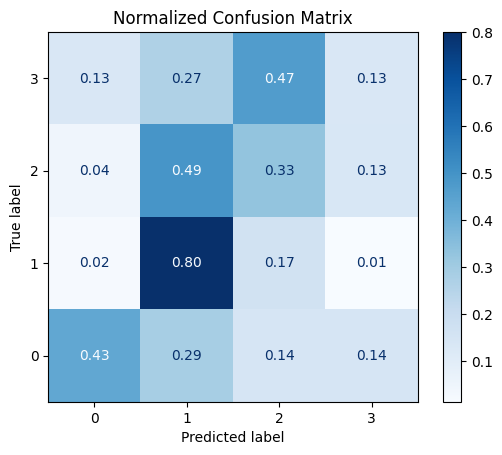

In [11]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)